Decision Tree Accuracy: 57.10%


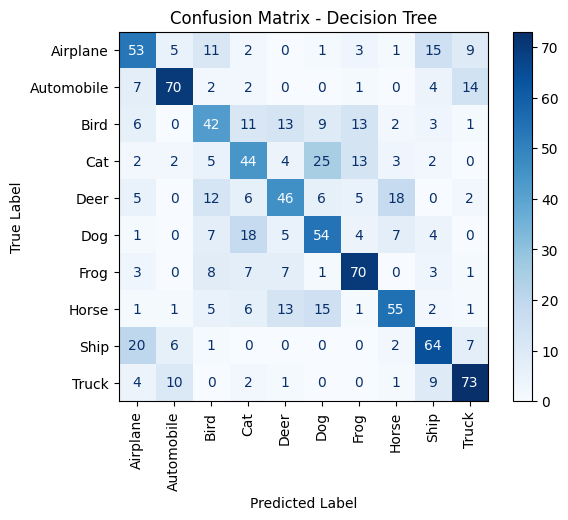

Metric     | Value     
-------------------------
Accuracy   | 0.5710
Precision  | 0.5702
Recall     | 0.5710
F1-Score   | 0.5697


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class DecisionTreeClassifier:
    def __init__(self, max_depth=50):
        self.max_depth = max_depth
        self.tree = None

    # Calculate Gini impurity
    def gini_impurity(self, y):
        _, counts = np.unique(y, return_counts=True)
        p = counts / len(y)
        return 1 - np.sum(p**2)

    # Split dataset based on a feature and a threshold
    def split(self, X, y, feature, threshold):
        left_mask = X[:, feature] <= threshold
        right_mask = X[:, feature] > threshold
        return (X[left_mask], y[left_mask]), (X[right_mask], y[right_mask])

    # Find the best split (feature and threshold) for the current node
    def find_best_split(self, X, y):
        n_features = X.shape[1]
        best_feature, best_threshold = None, None
        best_gini = float('inf')
        best_splits = None
        
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])  # Try each unique value as a threshold
            for threshold in thresholds:
                (X_left, y_left), (X_right, y_right) = self.split(X, y, feature, threshold)
                
                # Skip invalid splits
                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                # Weighted Gini impurity
                gini_left = self.gini_impurity(y_left)
                gini_right = self.gini_impurity(y_right)
                weighted_gini = (len(y_left) * gini_left + len(y_right) * gini_right) / len(y)

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature
                    best_threshold = threshold
                    best_splits = (X_left, y_left), (X_right, y_right)

        return best_feature, best_threshold, best_splits

    # Build the tree recursively
    def build_tree(self, X, y, depth=0):
        # Check stopping criteria
        if depth >= self.max_depth or len(np.unique(y)) == 1 or len(y) < 2:
            return {'label': np.bincount(y).argmax()} 

        # Find the best split
        feature, threshold, splits = self.find_best_split(X, y)
        if not splits: 
            return {'label': np.bincount(y).argmax()}

        (X_left, y_left), (X_right, y_right) = splits

        # Create a dictionary to represent the current node
        return {
            'feature': feature,
            'threshold': threshold,
            'left': self.build_tree(X_left, y_left, depth + 1),
            'right': self.build_tree(X_right, y_right, depth + 1)
        }

    # Fit the decision tree to the training data
    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    # Predict for a single data point
    def predict_single(self, x, node):
        if 'label' in node:  # If leaf node
            return node['label']
        if x[node['feature']] <= node['threshold']:
            return self.predict_single(x, node['left'])
        else:
            return self.predict_single(x, node['right'])

    # Predict for a batch of data points
    def predict(self, X):
        return np.array([self.predict_single(x, self.tree) for x in X])


if __name__ == "__main__":
    # Load the CIFAR-10 feature vectors and labels
    train_features = np.load('train_features_pca.npy')
    train_labels = np.load('train_labels.npy')
    test_features = np.load('test_features_pca.npy')
    test_labels = np.load('test_labels.npy')

    # Initialize the classifier
    dt = DecisionTreeClassifier(max_depth=50)

    # Fit the classifier on the training data
    dt.fit(train_features, train_labels)

    # Make predictions on the test data
    predictions = dt.predict(test_features)


    # 1. Confusion Matrix Visualization
    class_labels = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]
    cm = confusion_matrix(test_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')  # Rotate x-axis labels if they overlap
    plt.title("Confusion Matrix - Decision Tree")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # 2. Metrics Table
    def calculate_metrics(y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        true_positives = np.diag(cm)
        false_positives = np.sum(cm, axis=0) - true_positives
        false_negatives = np.sum(cm, axis=1) - true_positives
        true_negatives = np.sum(cm) - (false_positives + false_negatives + true_positives)
        
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1_score = 2 * (precision * recall) / (precision + recall)
        accuracy = np.sum(true_positives) / np.sum(cm)
        
        return accuracy, precision, recall, f1_score

    # Calculate metrics
    accuracy, precision, recall, f1_score = calculate_metrics(test_labels, predictions)

    # Print metrics in a table format
    print(f"{'Metric':<10} | {'Value':<10}")
    print("-" * 25)
    print(f"Accuracy   | {accuracy:.4f}")
    print(f"Precision  | {np.mean(precision):.4f}")
    print(f"Recall     | {np.mean(recall):.4f}")
    print(f"F1-Score   | {np.mean(f1_score):.4f}")
